In [20]:
!pip install -q python-dotenv
!pip install -q gradio
!pip install -q unstructured
!pip install -q openpyxl
!pip install -q tiktoken
!pip install -q chromadb
!pip install -q sentence-transformers
!pip install -q --upgrade langchain
!pip install -q -U langchain-chroma
!pip install -q -U langchain-google-vertexai
!pip install -q -U langchain-community
!pip install -q -U langchain langchain-huggingface
!pip install -q sqlalchemy

In [42]:
import os
import glob
import json
import chromadb
import gradio as gr
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import google.generativeai as genai
from dotenv import load_dotenv
from openai import OpenAI
from chromadb import chromadb
from sklearn.manifold import TSNE
from datetime import datetime
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, insert, Float, DateTime, inspect
#from google.colab import userdata

In [2]:
# imports for langchain

from langchain.document_loaders import DirectoryLoader, TextLoader, UnstructuredExcelLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain.embeddings import OpenAIEmbeddings, SentenceTransformerEmbeddings, HuggingFaceEmbeddings 
from langchain.vectorstores import Chroma
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate
from langchain_chroma import Chroma
from langchain_google_vertexai import ChatVertexAI #Import ChatVertexAI from langchain_google_vertexai
from pydantic import BaseModel

from chromadb import Client, Settings 

In [77]:
# Load environment variables in a file called .env

load_dotenv()
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY', 'your-key-if-not-using-env')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')


In [78]:
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])
Gemini_model = genai.GenerativeModel("gemini-1.5-flash")
MODEL = "gemini-1.5-flash" 
#Testing Gemini AI
#response = model.generate_content("Explain how AI works")
#print(response.text)

In [79]:
# Initialize Vertex AI with your Project ID and location
PROJECT_ID = "gen-lang-client-0840327518"  # Replace with your actual Project ID
LOCATION = "asia-southeast1" #Replace with your location
from vertexai import init
init(project=PROJECT_ID, location=LOCATION)

# Define a base language model (if you haven't already)
class _LanguageModel(BaseModel):
    pass


In [6]:
# Load environment variables in google Colab
# openai = userdata.get('OPENAI_API_KEY')
# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [80]:
# price is a factor for our company, so we're going to use a low cost model
db_name = "vector_db"

In [131]:
# Knowledge base is in /RAG_ImEx/Data
#knowledge_base_path = "Data/*"  
# Knowledge base is in /RAG_ImEx/Data
knowledge_base_path = "Data_test/*"  

In [82]:
# *** Timestamp Handling ***
def convert_timestamps(cell):
    """Converts Excel timestamps (float or datetime) to ISO 8601 strings."""
    if isinstance(cell, (float, int)):  # Check for numeric timestamps
        try:
            return pd.Timestamp(cell, unit='D').isoformat()  # Convert to datetime and then ISO string
        except ValueError:
            return cell #If the cell is not a valid timestamp, return the original value
    elif isinstance(cell, datetime): #Check if the cell is already in datetime format
        return cell.isoformat() #Return the ISO format of the datetime
    return cell  # Return other cell types unchanged

                

In [83]:
def combine_excel_files(knowledge_base_path, columns_to_remove=None, address_cols=None, header_translations=None):
    """
    Combines multiple Excel files into a single JSON string, handling variations in
    column positions and optional column removal/address merging.

    Args:
        knowledge_base_path: A glob pattern (e.g., "path/to/files/*.xlsx").
        columns_to_remove (optional): A list of column names to remove.
        address_cols (optional): A list of address column names to merge.
        header_translations (optional): Whether to merge address columns.
    Returns:
        A JSON string containing the combined data, or None if an error occurs.
        Prints error messages to the console.
    """

    excel_files = []
    all_data = []

    # Find all Excel files based on the provided path (can be a glob pattern)
    initial_paths = glob.glob(knowledge_base_path)
    
    
    for path in initial_paths:
        if os.path.isdir(path):
            excel_files.extend(glob.glob(os.path.join(path, "*.xlsx"))) # Add Excel files from subdirectories
        elif os.path.isfile(path) and path.lower().endswith(('.xls', '.xlsx')):
            excel_files.append(path)
        else:
            print(f"Skipping: {path} (Not a directory or an Excel file)")

    if not excel_files:
        print(f"No Excel files found matching pattern: {knowledge_base_path}")
        return None

    for file_path in excel_files:
        try:
            if os.path.isdir(file_path): # redundant check, already handled above.
                print(f"Skipping directory: {file_path}")
                continue

            print(f"Processing file: {file_path}")
            df = pd.read_excel(file_path)
            '''
            # Convert all relevant columns to string type *before* any string operations
            for col in df.columns:
                # Check if the column has mixed types or if it's numeric
                if pd.api.types.is_numeric_dtype(df[col]) or not all(isinstance(x, str) or pd.isna(x) for x in df[col]):
                    df[col] = df[col].astype(str)  # Convert the column to string type
            '''
            # Convert column names to lowercase for consistency. Do this early.
            df.columns = df.columns.str.lower()
            if columns_to_remove:
                columns_to_remove = [col.lower() for col in columns_to_remove]
            if address_cols:
                address_cols = [col.lower() for col in address_cols]
            if header_translations:
                header_translations = {k.lower(): v for k, v in header_translations.items()}
            
            # Merge address columns if specified and all columns are present.
            if address_cols and all(col in df.columns for col in address_cols):
                df['dia chi don vi doi tac'] = df[address_cols].apply(lambda row: ' '.join(row.dropna()), axis=1)
                df = df.drop(address_cols, axis=1)
            elif address_cols and not all(col in df.columns for col in address_cols):
                print(f"Warning: Not all address columns found in {file_path}. Skipping address merge.")
           
            # Remove specified columns.
            if columns_to_remove:
                for col in columns_to_remove:
                    try:
                        df = df.drop(col, axis=1)
                    except KeyError:
                        print(f"Warning: Column '{col}' not found in {file_path}. Skipping.")
                    except Exception as e:
                        print(f"An error occurred during column removal in {file_path}: {e}")
                        return None  # Stop processing if a general exception occurs
            
            # header translations.
            if header_translations:
                try:
                    df = df.rename(columns=header_translations)
                except KeyError as e:  # Handle cases where translation key is not found
                    print(f"Error translating headers: Key '{e}' not found in DataFrame.")
                except Exception as e: # Catch other potential exceptions
                    print(f"An error occurred during header translation: {e}")
                    return None
            
            # Convert datetime columns to ISO format strings.
            for col in df.columns:
                if df[col].dtype == 'datetime64[ns]':
                    df[col] = df[col].apply(lambda x: x.isoformat() if pd.notna(x) else None)
            
            # Convert DataFrame to a list of dictionaries.
            data = df.to_dict(orient='records')
            '''
            # Create a dictionary with metadata and the data.
            document_meta = {"doc_path": file_path, "doc_type": "DataBase", "text": data}
            '''
            all_data.append(data)
            
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            return None

    #return json.dumps(all_data, ensure_ascii=False, indent=4)
    return all_data

In [84]:
def df_to_sql_file(df_list, output_sql_file, table_name_prefix="table", if_exists='replace'):
    try:
        engine = create_engine('sqlite:///:memory:')
        metadata = MetaData()
        inspector = inspect(engine)

        with open(output_sql_file, 'w', encoding='utf-8') as f:
            for i, data in enumerate(df_list):
                df = pd.DataFrame(data)
                table_name = f"{table_name_prefix}_{i}"

                # Check if DataFrame has NO ROWS *before* defining columns
                if len(df) == 0:
                    print(f"Warning: DataFrame for table '{table_name}' has no rows. Skipping table creation.")
                    f.write(f"-- WARNING: DataFrame for table '{table_name}' has no rows. Skipping table creation.\n\n")
                    continue

                # Define columns dynamically with type mapping
                columns = []
                for col_name, dtype in df.dtypes.items():
                    if pd.api.types.is_integer_dtype(dtype):
                        col_type = Integer
                    elif pd.api.types.is_float_dtype(dtype):
                        col_type = Float
                    elif pd.api.types.is_datetime64_any_dtype(dtype):
                        col_type = DateTime
                    elif pd.api.types.is_string_dtype(dtype) or pd.api.types.is_object_dtype(dtype):
                        col_type = String
                    else:
                        col_type = String  # Default to String

                    columns.append(Column(col_name, col_type))  # Correct Indentation Here

                my_table = Table(table_name, metadata, *columns)


                # Correctly handle if_exists logic with SQLAlchemy Core:
                if if_exists == 'replace':
                    if inspector.has_table(table_name):
                        with engine.connect() as conn:  # Use a connection context
                            conn.execute(my_table.drop(engine)) # Drop using the connection.
                    metadata.create_all(engine) # Create the table.
                elif if_exists == 'fail':
                    if inspector.has_table(table_name):
                        raise Exception(f"Table '{table_name}' already exists.")
                    metadata.create_all(engine)
                elif if_exists == 'append':
                    if not inspector.has_table(table_name):
                        metadata.create_all(engine)

                f.write(f"-- SQL commands for table: {table_name}\n")
                for statement in metadata.create_all(engine, checkfirst=False):
                    f.write(str(statement) + ";\n")

                for index, row in df.iterrows():
                    ins = my_table.insert().values(row.to_dict())
                    f.write(str(ins) + ";\n")

                f.write("\n")

        print(f"DataFrames written to SQL file: {output_sql_file}")

    except Exception as e:
        print(f"Error writing DataFrames to SQL file: {e}")

    finally:
        engine.dispose()

In [85]:
columns_to_remove = [
    'MA HQ', 'MA HAI QUAN', 'MA CHI CUC',
    'TEN HAI QUAN', 'SO DT', 'DIA DIEM CHO THONG QUAN',
    'DIA DIEM CHO THONG QUAN',
    'DIA DIEM DO HANG', 'DIA DIEM XEP HANG', 'P.TIEN V.CHUYEN', 'Tri GIA'
]
address_cols = ['dia chi 1', 'dia chi 2', 'dia chi 3', 'dia chi 4']

header_translations = {
    "MA LH": "Import_Code", 
    "NHA NHAP KHAU" : "Cty nhập khẩu",
    "DIA CHI" : "Địa chỉ cty nhập ",
    "DON VI DOI TAC":"Cty bán hàng", 
    "DIA CHI DON VI DOI TAC" : "Địa chỉ cty bán hàng",
    "DK TT": "Hình Thức Thanh Toán",
    "DK GH": "Incoterm",
    "TI GIA": "Exchange_Rate",
    "NGAY" : "Date",
    "MA HANG" : "HSCODE",
    "TEN HANG": "Product_Info", 
    "LUONG": "Quantity",
    "DVT" : "Unit",
    "DON GIA" : "Unit_Price",
    "MA NT": "Payment_Currency",
    "THUE XNK" : "Import_Tax",
    "XUAT XU" : "Origin", 
    "MA DOANH NGHIEP" : "Tax ID",
}
combined_df = combine_excel_files(knowledge_base_path, columns_to_remove, address_cols, header_translations)

if combined_df is not None:
    print("Combined DataFrame:")
    #print(combined_df)  # Keep this for checking the data


Processing file: Data_test\Raw Data\72NK.T1.2024test.xlsx
Processing file: Data_test\Raw Data\72NK.T3.2024test.xlsx
Processing file: Data_test\Raw Data\72XK.T6.2024test.xlsx
Processing file: Data_test\Raw Data\72XK.T8.2021test.xlsx
Combined DataFrame:


In [86]:
# Convert to LangChain Documents(this is the crucial step)
langchain_documents = []
for file_data in combined_df:  # Iterate through each list of dictionaries (each Excel file's data)
    for doc in file_data: # Iterate through the dictionaries in the list. Each dict is one row.
        metadata = {'source_file': 'DataBase'} # Add metadata, if you have a doc_path
        page_content = ""
        for key, value in doc.items():
                page_content += f"{key}: {value}\n"
        langchain_doc = Document(page_content=page_content, metadata=metadata)
        langchain_documents.append(langchain_doc)

print(f"Created {len(langchain_documents)} LangChain documents.")

Created 85 LangChain documents.


In [87]:
langchain_documents[1]

Document(metadata={'source_file': 'DataBase'}, page_content='Import_Code: A12\nTax ID: 101095255\nCty nhập khẩu: CôNG TY TNHH HANWA SMC STEEL SERVICE Hà NộI\nĐịa chỉ cty nhập : Lô số 47, Khu công nghiệp Quang Minh, thị trấn Quang Minh, huyện Mê Linh, TP Hà Nội, Việt Nam\nCty bán hàng: GUANGZHOU HANWA TRADING CO., LTD.\nIncoterm: CFR\nPayment_Currency: USD\nExchange_Rate: 24060.0\nDate: 2024-01-03T00:00:00\nHSCODE: 72259190\nProduct_Info: Thép hợp kim (Bo > 0.0008%), dạng cuộn, cán phẳng, được mạ kẽm bằng phương pháp điện phân, mác SECC-MD1 (tương đương SECC JIS G3313), mới 100%. KT: 1.6 mm x 1050 mm x Cuộn.Mã số chương 98 : 98110010\nQuantity: 19910\nUnit: KGM\nUnit_Price: 0.861\nĐịa chỉ cty bán hàng: UNIT 3701-3703, PROFIT PLAZA NO. 76. WEST HUANGPU ROAD GUANGZHOU CHINA, 510623\n')

In [88]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(langchain_documents)

In [89]:
len(chunks)

85

In [90]:
print(chunks[1])

page_content='Import_Code: A12
Tax ID: 101095255
Cty nhập khẩu: CôNG TY TNHH HANWA SMC STEEL SERVICE Hà NộI
Địa chỉ cty nhập : Lô số 47, Khu công nghiệp Quang Minh, thị trấn Quang Minh, huyện Mê Linh, TP Hà Nội, Việt Nam
Cty bán hàng: GUANGZHOU HANWA TRADING CO., LTD.
Incoterm: CFR
Payment_Currency: USD
Exchange_Rate: 24060.0
Date: 2024-01-03T00:00:00
HSCODE: 72259190
Product_Info: Thép hợp kim (Bo > 0.0008%), dạng cuộn, cán phẳng, được mạ kẽm bằng phương pháp điện phân, mác SECC-MD1 (tương đương SECC JIS G3313), mới 100%. KT: 1.6 mm x 1050 mm x Cuộn.Mã số chương 98 : 98110010
Quantity: 19910
Unit: KGM
Unit_Price: 0.861
Địa chỉ cty bán hàng: UNIT 3701-3703, PROFIT PLAZA NO. 76. WEST HUANGPU ROAD GUANGZHOU CHINA, 510623' metadata={'source_file': 'DataBase'}


In [91]:
# Choose a suitable model.  'all-mpnet-base-v2' is a good general-purpose option.
embeddings = SentenceTransformerEmbeddings(model_name="all-mpnet-base-v2")  # Or another Sentence Transformer model
# Delete if already exists
if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

In [92]:
vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name) # Use the chunks (which are LangChain Documents)

In [93]:
# Let's investigate the vectors

collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 85 vectors with 768 dimensions in the vector store


In [94]:
doc_types = set(chunk.metadata['source_file'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: DataBase


In [ ]:
'''
results = collection.get(include=['embeddings', 'documents', 'metadatas'])
print(results)
'''
results = collection.get(include=['embeddings'])
print(results)

In [95]:
# Prework
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
doc_types = [metadata['source_file'] for metadata in result['metadatas']]
colors = [['blue'][['DataBase'].index(t)] for t in doc_types]

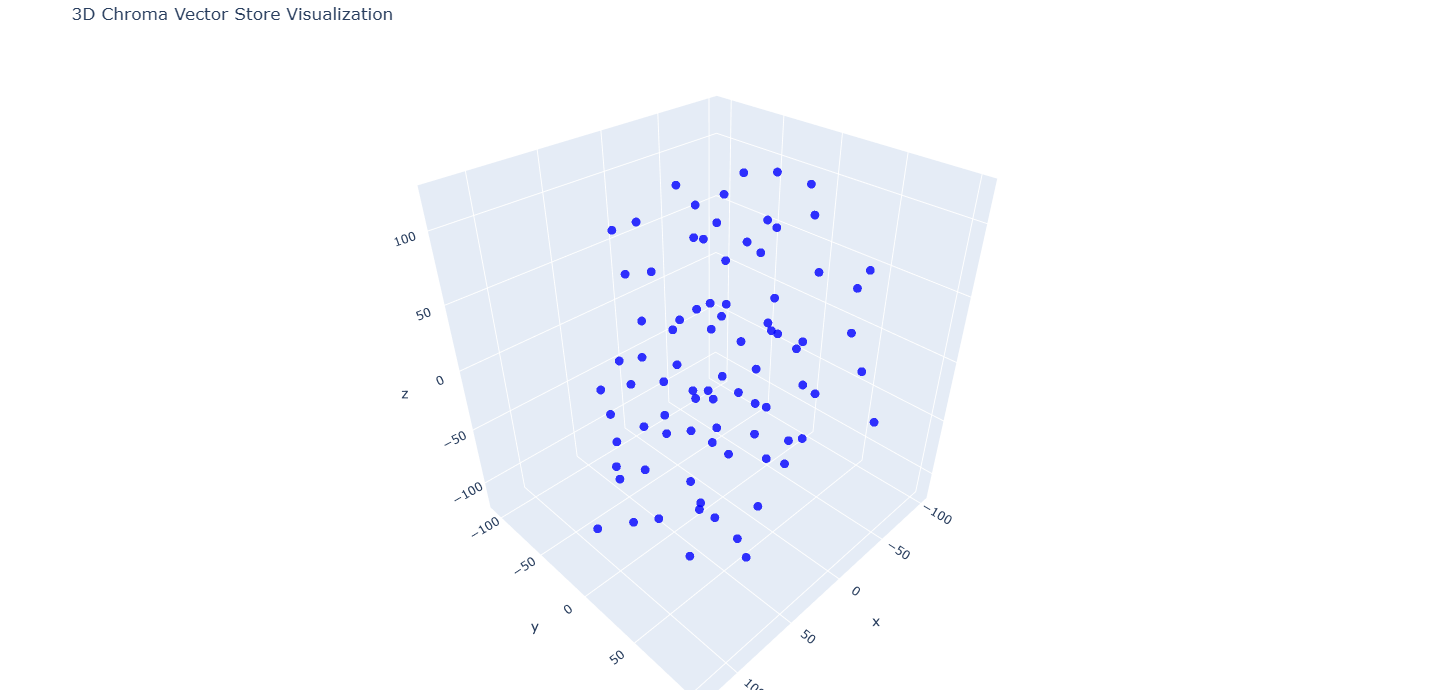

In [96]:
# Let's try 3D!
tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [97]:
# create a new Chat with Gemini
#llm = ChatVertexAI(temperature=0.7, model_name=MODEL)
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name="gpt-4o-mini")

# Rebuild the model (this is the crucial missing step)
ChatVertexAI.model_rebuild()

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever(search_kwargs={"k": 25})

# Putting it together: set up the conversation chain with Gemini, 
# the vector store, and memory
conversation_chain = ConversationalRetrievalChain.from_llm(
    llm=llm, 
    retriever=retriever, 
    memory=memory
)

In [98]:
query = "what VSSC steel center importing?"
result = conversation_chain.invoke({"question":query})
print(result["answer"])

VSSC Steel Center is importing various types of steel products, specifically:

1. **Non-alloy Cold Rolled Flat Steel** - This includes products that are painted after coating and galvanized, with specifications such as carbon content less than 0.6% and various thicknesses and widths.

2. **Non-alloy Hot Rolled Flat Steel** - This includes products that are unprocessed beyond hot rolling, uncoated, and in new condition.

The specific products include different grades and dimensions of cold rolled and hot rolled flat steel sheets.


In [99]:
# set up a new conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [100]:
# Wrapping in a function - note that history isn't used, as the memory is in the conversation_chain

def chat(message, history):
    result = conversation_chain.invoke({"question": message})
    return result["answer"]

In [101]:
# And in Gradio:

view = gr.ChatInterface(chat, type="messages").launch(inbrowser=False, share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://9e45003a8e98b4b327.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [103]:
from langchain_core.callbacks import StdOutCallbackHandler
llm = ChatOpenAI(temperature=0.7, model_name="gpt-4o-mini")
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)
retriever = vectorstore.as_retriever(search_kwargs={"k": 25})
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory, callbacks=[StdOutCallbackHandler()])

query = "what VSSC steel center import?"
result = conversation_chain.invoke({"question": query})
answer = result["answer"]
print("\nAnswer:", answer)



> Entering new ConversationalRetrievalChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
Import_Code: E31
Tax ID: 3502447502
Cty nhập khẩu: CôNG TY TNHH VSSC STEEL CENTER
Địa chỉ cty nhập : Đường N7 Khu công nghiệp Phú Mỹ II, Phường Tân Phước, Thị xã Phú Mỹ, Tỉnh Bà Rịa - Vũng Tàu,Việt Nam
Cty bán hàng: SAMSUNG C AND T CORPORATION
Incoterm: CIF
Payment_Currency: USD
Exchange_Rate: 24060.0
Date: 2024-01-04T00:00:00
HSCODE: 72107012
Product_Info: PCM#&Thép không hợp kim cán phẳng dạng cuộn; cán nguội; được sơn sau khi phủ, mạ kẽm; Cacbon < 0.6%; dày 0.4mm; rộng 735mm; DA01-01523A;TC: JIS G 3312;NSX: SUZHOU XING HEYUAN SPECIAL MATERIAL.Mới 100%
Quantity: 36024
Unit: KGM
Unit_Price: 1.07
Địa chỉ cty bán hàng: 67, SEJONG-DAERO, JUNG-GU SE